In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

In [3]:
boston = load_boston()


# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)



In [4]:
X_DATA = X_bos_pd[["CRIM","AGE"]].head(300)
Y_DATA = Y_bos_pd.head(300)

X_DATA.insert(0,"target",Y_DATA)

In [5]:
data = X_DATA

data

,target,CRIM,AGE
0,24.0,0.00632,65.2
1,21.6,0.02731,78.9
2,34.7,0.02729,61.1
3,33.4,0.03237,45.8
4,36.2,0.06905,54.2
...,...,...,...
295,28.6,0.12932,31.1
296,27.1,0.05372,51.0
297,20.3,0.14103,58.0
298,22.5,0.06466,20.1


In [6]:
# We split the dataset into 2/3 training and 1/3 testing sets.
train_data, test_data = sklearn.model_selection.train_test_split(data, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
train_data, val_data = sklearn.model_selection.train_test_split(train_data, test_size=0.33)

In [7]:
print("train_data : ", len(train_data))
print("test_data : ", len(test_data))
print("val_data : ", len(val_data))

val_data

train_data :  134
test_data :  99
val_data :  67


,target,CRIM,AGE
13,20.4,0.62976,61.8
141,14.4,1.62864,100.0
177,24.6,0.05425,73.4
17,17.5,0.78420,81.7
199,34.9,0.03150,15.3
...,...,...,...
169,22.3,2.44953,95.2
248,24.5,0.16439,49.1
164,22.7,2.24236,91.8
221,21.7,0.40771,91.3


In [8]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# X_DATA = X_bos_pd[["CRIM","AGE"]].head(30)

X_test = test_data[["CRIM","AGE"]]
Y_test = test_data[["target"]]
    
# test_data.to_csv(os.path.join(data_dir, 'test_3.csv'), header=False, index=False)
X_test.to_csv(os.path.join(data_dir, 'test_3.csv'), header=False, index=False)
train_data.to_csv(os.path.join(data_dir, 'train_3.csv'), header=False, index=False)
val_data.to_csv(os.path.join(data_dir, 'val_3.csv'), header=False, index=False)


# X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
X_test

,CRIM,AGE
165,2.92400,93.0
252,0.08221,6.8
269,0.09065,61.5
182,0.09103,92.2
121,0.07165,84.1
...,...,...
117,0.15098,82.6
150,1.65660,97.3
220,0.35809,88.5
95,0.12204,57.8


In [9]:
prefix = 'boston-xgboost-HL-tutorial-3'

test_location = session.upload_data(os.path.join(data_dir, 'test_3.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'val_3.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train_3.csv'), key_prefix=prefix)

In [10]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [11]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [12]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-13 12:18:52 Starting - Starting the training job...
2020-09-13 12:18:56 Starting - Launching requested ML instances......
2020-09-13 12:20:19 Starting - Preparing the instances for training......
2020-09-13 12:21:12 Downloading - Downloading input data...
2020-09-13 12:21:53 Training - Training image download completed. Training in progress.
2020-09-13 12:21:53 Uploading - Uploading generated training model.Arguments: train
[2020-09-13:12:21:48:INFO] Running standalone xgboost training.
[2020-09-13:12:21:48:INFO] File size need to be processed in the node: 0.0mb. Available memory size in the node: 8477.55mb
[2020-09-13:12:21:48:INFO] Determined delimiter of CSV input is ','
[12:21:48] S3DistributionType set as FullyReplicated
[12:21:48] 134x2 matrix with 268 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-09-13:12:21:48:INFO] Determined delimiter of CSV input is ','
[12:21:48] S3DistributionType set as FullyReplicated
[12:21:48] 67x2 mat

In [13]:
# TEST THE MODEL

In [14]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


...........................
2020-09-13T12:26:52.083:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
[2020-09-13 12:26:51 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-09-13 12:26:51 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-09-13 12:26:51 +0000] [1] [INFO] Using worker: gevent
[2020-09-13 12:26:51 +0000] [36] [INFO] Booting worker with pid: 36
[2020-09-13 12:26:52 +0000] [37] [INFO] Booting worker with pid: 37
[2020-09-13 12:26:52 +0000] [38] [INFO] Booting worker with pid: 38
[2020-09-13:12:26:52:INFO] Model loaded successfully for worker : 36
[2020-09-13 12:26:52 +0000] [39] [INFO] Booting worker with pid: 39
Arguments: serve
[2020-09-13 12:26:51 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-09-13 12:26:51 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-09-13 12:26:51 +0000] [1] [INFO] Using worker: gevent
[2020-09-13 12:26:51 +0000] [36] [INFO] Booting worker with pid: 36
[2020-09-13 1

In [15]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-2-360760555806/xgboost-2020-09-13-12-22-34-617/test_3.csv.out to ../data/boston/test_3.csv.out


Text(0.5, 1.0, 'Median Price vs Predicted Price')

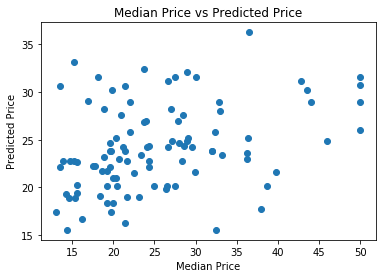

In [16]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test_3.csv.out'), header=None)
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

In [17]:
Y_pred

,0
0,20.170038
1,24.214754
2,22.986887
3,17.770826
4,20.999968
...,...
94,20.146400
95,30.645147
96,31.129871
97,22.741751


In [18]:
df = Y_test.rename(columns={'newName1': 'test'}).reset_index(drop=True)

df["predict"] = Y_pred

df

,target,predict
0,25.0,20.170038
1,29.6,24.214754
2,20.7,22.986887
3,37.9,17.770826
4,20.3,20.999968
...,...,...
94,19.2,20.146400
95,21.5,30.645147
96,26.7,31.129871
97,28.4,22.741751


In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score

rms = sqrt(mean_squared_error(Y_test, Y_pred))
mae = MAE(Y_test, Y_pred)
r_score = r2_score(Y_test, Y_pred)


In [20]:


print("rms : " , rms)
print("mae  :", mae)
print("r_score : ", r_score)

rms :  8.633593067613054
mae  : 6.466743623366664
r_score :  0.09208043228470919


In [21]:
# DEPLOY MODEL
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: xgboost-2020-09-13-12-18-52-193


-------------!

In [22]:
# use MODEL
# We need to tell the endpoint what format the data we are sending is in
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

Y_pred = xgb_predictor.predict(X_test.values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up
# as a numpy array.
Y_pred

'20.1700382233,24.2147541046,22.9868869781,17.7708263397,20.9999675751,18.8865070343,31.5938949585,29.1063518524,27.9813518524,32.0621414185,25.7928714752,25.15325737,20.1464004517,24.8543682098,24.2349300385,22.6597938538,20.9999675751,25.15325737,21.7203197479,22.7417507172,28.9135379791,19.2905387878,27.6269607544,28.9135379791,19.0814437866,23.8061790466,20.1464004517,25.15325737,24.8565597534,15.5663108826,24.2996921539,17.4242229462,24.2996921539,23.8061790466,18.8865070343,32.4088516235,18.9647808075,27.6269607544,23.3611888885,28.2245159149,18.4202384949,21.5344390869,24.6406650543,23.8061790466,16.6907367706,22.9868869781,21.6395835876,23.8061790466,30.7310752869,22.7722702026,20.2340888977,21.7203197479,16.2235603333,24.8565597534,24.6869373322,22.7722702026,31.1167449951,23.2135009766,22.1091480255,25.7928714752,31.5938949585,23.8061790466,23.5953159332,28.1922149658,36.2697792053,31.5938949585,22.1091480255,30.2761192322,22.2679271698,18.9647808075,21.6395835876,15.55989265

In [23]:
Y_pred = np.fromstring(Y_pred, sep=',')

Y_pred

array([20.17003822, 24.2147541 , 22.98688698, 17.77082634, 20.99996758,
       18.88650703, 31.59389496, 29.10635185, 27.98135185, 32.06214142,
       25.79287148, 25.15325737, 20.14640045, 24.85436821, 24.23493004,
       22.65979385, 20.99996758, 25.15325737, 21.72031975, 22.74175072,
       28.91353798, 19.29053879, 27.62696075, 28.91353798, 19.08144379,
       23.80617905, 20.14640045, 25.15325737, 24.85655975, 15.56631088,
       24.29969215, 17.42422295, 24.29969215, 23.80617905, 18.88650703,
       32.40885162, 18.96478081, 27.62696075, 23.36118889, 28.22451591,
       18.42023849, 21.53443909, 24.64066505, 23.80617905, 16.69073677,
       22.98688698, 21.63958359, 23.80617905, 30.73107529, 22.7722702 ,
       20.2340889 , 21.72031975, 16.22356033, 24.85655975, 24.68693733,
       22.7722702 , 31.116745  , 23.21350098, 22.10914803, 25.79287148,
       31.59389496, 23.80617905, 23.59531593, 28.19221497, 36.26977921,
       31.59389496, 22.10914803, 30.27611923, 22.26792717, 18.96

Text(0.5, 1.0, 'Median Price vs Predicted Price')

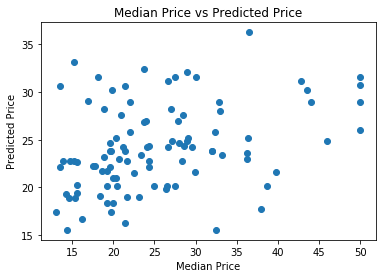

In [24]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

In [25]:
# delete endpoint
xgb_predictor.delete_endpoint()

In [26]:
df = Y_test.rename(columns={'newName1': 'test'}).reset_index(drop=True)

df["predict"] = Y_pred

df

,target,predict
0,25.0,20.170038
1,29.6,24.214754
2,20.7,22.986887
3,37.9,17.770826
4,20.3,20.999968
...,...,...
94,19.2,20.146400
95,21.5,30.645147
96,26.7,31.129871
97,28.4,22.741751


In [27]:
rms = sqrt(mean_squared_error(Y_test, Y_pred))
mae = MAE(Y_test, Y_pred)
r_score = r2_score(Y_test, Y_pred)

In [28]:
print("rms : " , rms)
print("mae  :", mae)
print("r_score : ", r_score)

rms :  8.633593067613054
mae  : 6.466743623366667
r_score :  0.09208043228470919


In [29]:
a = [1,2,3]

a

[1, 2, 3]

In [30]:
b = "2020,2034,2333"

b_value = np.fromstring(b, sep=',')

b_value

array([2020., 2034., 2333.])